# Proyecto análisis pruebas A/B

Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

**Descripción técnica:**
- Nombre de la prueba: recommender_system_test
- Grupos: А (control), B (nuevo embudo de pago)
- Fecha de lanzamiento: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento product_page), instancias de agregar artículos al carrito de compras (product_cart) y compras (purchase). En cada etapa del embudo product_page → product_cart → purchase, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000


---


In [33]:
# Cargamos las librerías que vamos a necesitar

import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats as st
import math as m
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Leemos los datasets
 
marketing_events = pd.read_csv('ab_project_marketing_events_us.csv')
new_users = pd.read_csv('final_ab_new_users_upd_us.csv')
events = pd.read_csv('final_ab_events_upd_us.csv')
participants = pd.read_csv('final_ab_participants_upd_us.csv')

## Revisar los datos:

In [35]:
print('Marketing Events:')
marketing_events.info()
marketing_events.head()

Marketing Events:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [36]:
print('New Users:')
new_users.info()
new_users.head()

New Users:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [37]:
print('Events:')
events.info()
events.head()

Events:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [38]:
print('Participants:')
participants.info()
participants.head()

Participants:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


### Observaciones:

- La columna 'details' tiene valores ausentes. Esto es esperado, ya que no todos los eventos tienen detalles adicionales (ej. login). Para nuestro análisis de conversión del embudo (contar eventos), esto no debería ser un problema. Esta columna significa datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos purchase), el resto de  datasets tienen los datos completos.

- Debemos cambiar el tipo de dato a **datetime** respectivamente en cada columna de fecha de cada dataset.

- Revisaremos si hay valores duplicados

---

## Exploración y Limpieza de Datos

In [39]:
# Conversión de Tipos de Datos (Fechas)

# Marketing Events
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

# New Users
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

# Events
events['event_dt'] = pd.to_datetime(events['event_dt'])

In [40]:
# Revisión de Duplicados
print("\n--- Filas Duplicadas Completas por DataFrame ---")
print(f"Marketing Events: {marketing_events.duplicated().sum()}")
print(f"New Users: {new_users.duplicated().sum()}")
print(f"Events: {events.duplicated().sum()}")
print(f"Participants: {participants.duplicated().sum()}")


--- Filas Duplicadas Completas por DataFrame ---
Marketing Events: 0
New Users: 0
Events: 0
Participants: 0


In [41]:
# También revisamos duplicados lógicos: ¿Un usuario en múltiples grupos?
participant_duplicates = participants.groupby('user_id')['group'].nunique().reset_index()
multiple_groups = participant_duplicates[participant_duplicates['group'] > 1]['user_id'].nunique()
if multiple_groups > 0:
    print(f"\nSe encontraron {multiple_groups} usuarios asignados a más de un grupo en 'participants'.")
else:
    print("\nVerificación: Ningún usuario encontrado en múltiples grupos en 'participants'.")


Se encontraron 441 usuarios asignados a más de un grupo en 'participants'.


### Conclusión: 

**Duplicados:**

- Verificamos filas completamente duplicadas con .duplicated().sum(). También realizamos una verificación lógica importante: si algún usuario (user_id) está asignado a más de un grupo (group) en participants, lo cual invalidaría parcialmente la prueba para esos usuarios.

---

## Filtrado:

In [42]:
# Filtrado y Consistencia de Datos

# 1. Filtrar usuarios de la región EU
users_eu = new_users[new_users['region'] == 'EU'][['user_id', 'first_date']]

# 2. Filtrar participantes del test correcto y que estén en la EU
participants_eu = participants[
    (participants['ab_test'] == 'recommender_system_test') &
    (participants['user_id'].isin(users_eu['user_id']))
]

# 3. Unir participantes con la fecha de registro
participants_eu = participants_eu.merge(users_eu, on='user_id')

# 4. Filtrar usuarios que se registraron en el rango válido
mask = participants_eu['first_date'].between('2020-12-07', '2020-12-21')
participants_in_period = participants_eu[mask]

# 5. Balancear los grupos A y B al tamaño del grupo más pequeño
min_group_size = participants_in_period['group'].value_counts().min()
balanced_participants = (
    participants_in_period
    .groupby('group', group_keys=False)
    .apply(lambda x: x.sample(min_group_size, random_state=42))
    .reset_index(drop=True)
)

# 6. Filtrar eventos finales de los usuarios válidos y balanceados
valid_user_ids = balanced_participants['user_id']
final_events = events[events['user_id'].isin(valid_user_ids)]

# 7. Asignar resultado final limpio
final_participants = balanced_participants

# Verificaciones
print("Participantes válidos y balanceados por grupo:")
print(final_participants['group'].value_counts())
print(f"Total eventos asociados: {len(final_events)}")


Participantes válidos y balanceados por grupo:
group
A    877
B    877
Name: count, dtype: int64
Total eventos asociados: 10828


/var/folders/yd/jr1h18jn6px95w7s343fr20h0000gp/T/ipykernel_1563/66928867.py:24: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



## Conclusión:

### Es un bloque para filtrar datos de usuarios y eventos y asegurar que:

- Solo se analicen usuarios de la Unión Europea.

- Solo se consideren participantes del experimento correcto (recommender_system_test).

- Todos los datos estén consistentes, con:

   - ***Usuarios válidos***

   - ***Fechas correctas de registro***

   - ***Y eventos relacionados con esos usuarios***

### **¿Qué hace paso a paso?**

1. Filtra usuarios de la región UE.
2. Filtra participantes del test correcto.
3. Filtra esos participantes para que sean solo de la UE.
4. Filtra los eventos que correspondan a esos usuarios válidos.
5. Verifica si hay inconsistencias en usuarios o fechas.
6. Actualiza los conjuntos de datos para análisis limpio.

---

## Cómo se distribuye el número de eventos entre los días

In [43]:
# Asegurar tipo datetime y extraer solo la fecha
final_events.loc[:, 'event_date'] = pd.to_datetime(final_events['event_dt']).dt.date


# Agregar la columna 'group' a final_events mediante merge con final_participants
events_with_group = pd.merge(final_events, final_participants[['user_id', 'group']], on='user_id', how='left')

# Agrupar por fecha y grupo para contar eventos
events_by_day_group = (
    events_with_group.groupby(['event_date', 'group'])['user_id']
    .count()
    .reset_index()
    .rename(columns={'user_id': 'event_count'})
)

# Graficar

import plotly.express as px
'''
fig = px.line(
    events_by_day_group,
    x='event_date',
    y='event_count',
    color='group',
    markers=True,
    title='Distribución de eventos por día y por grupo',
    labels={'event_date': 'Fecha', 'event_count': 'Cantidad de eventos'}
)

fig.update_layout(xaxis_title='Fecha', yaxis_title='Cantidad de Eventos', xaxis=dict(tickformat='%Y-%m-%d'))
fig.show()
'''

/var/folders/yd/jr1h18jn6px95w7s343fr20h0000gp/T/ipykernel_1563/2295630914.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



"\nfig = px.line(\n    events_by_day_group,\n    x='event_date',\n    y='event_count',\n    color='group',\n    markers=True,\n    title='Distribución de eventos por día y por grupo',\n    labels={'event_date': 'Fecha', 'event_count': 'Cantidad de eventos'}\n)\n\nfig.update_layout(xaxis_title='Fecha', yaxis_title='Cantidad de Eventos', xaxis=dict(tickformat='%Y-%m-%d'))\nfig.show()\n"

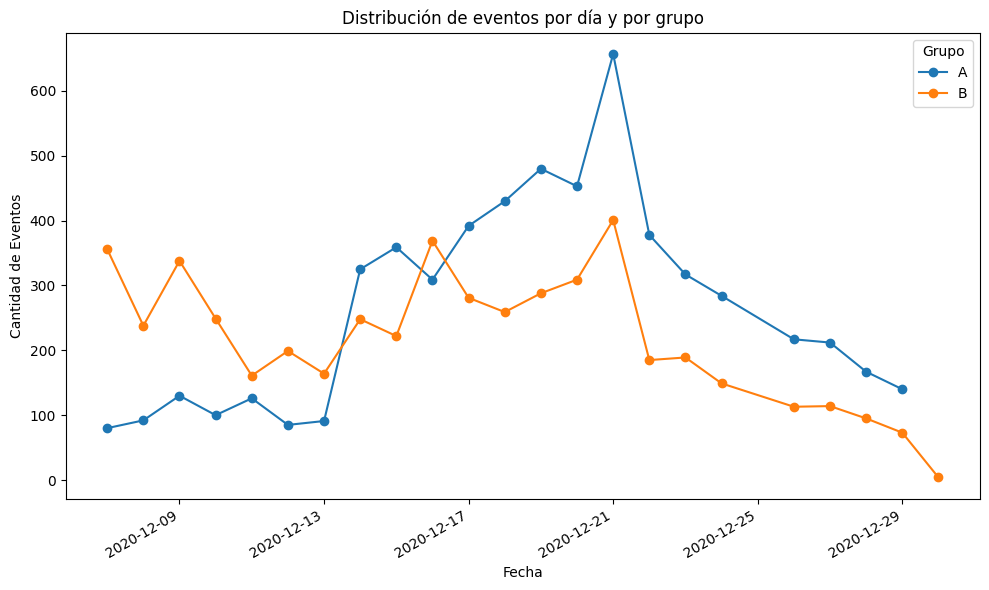

In [44]:
import matplotlib.dates as mdates

# Asegúrate de que 'event_date' sea tipo datetime
#events_by_day_group['event_date'] = pd.to_datetime(events_by_day_group['event_date'])

# Crear figura
plt.figure(figsize=(10,6))

# Graficar cada grupo por separado
for group_name, group_data in events_by_day_group.groupby('group'):
    plt.plot(
        group_data['event_date'],
        group_data['event_count'],
        marker='o',
        label=group_name
    )

# Título y etiquetas
plt.title('Distribución de eventos por día y por grupo')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Eventos')

# Formato de fechas en el eje X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rota las fechas para que no se encimen

# Leyenda
plt.legend(title='Grupo')

# Mostrar
plt.tight_layout()
plt.show()

### Conclusión:
 El grupo B comenzó con una alta cantidad de eventos en comparación del grupo A pero conforme van pasando los días el se van estabilizando los grupos pero siendo ahora el grupo A el que acumula mayor cantidad de eventos a partir del 2020-12-14

**Distribución Similar Entre Grupos:**

Ambos grupos muestran una forma de curva parecida (tendencias temporales similares).
Esto sugiere que el sistema asignó usuarios a grupos correctamente y que no hubo errores que favorezcan un grupo sobre otro durante ciertos días.

**Volumen de Actividad Diario:**

Hubo días con picos y caídas en el número de eventos.
Si hay ciertos días con muchos más eventos, podría deberse a:

- Campañas de marketing.
- Ciclos naturales de uso (por ejemplo, má uso en fines de semana).

---

## Análisis Exploratorio de Datos (EDA)

Usaremos los DataFrames final_participants y final_events que preparamos.

1. Análisis del Embudo de Conversión (Considerando Ventana de 14 días)

El objetivo es ver cuántos usuarios de cada grupo (A y B) pasan por las etapas product_page -> product_card -> purchase dentro de los 14 días siguientes a su fecha de registro (first_date).

## Filtrado por 14 días:
Se repite el proceso crucial de unir eventos con la fecha de registro y filtrar solo aquellos dentro de los 14 días.

In [45]:
# Unir eventos con la fecha de registro de los participantes
events_merged = pd.merge(
    final_events[['user_id', 'event_dt', 'event_name']],
    final_participants[['user_id', 'group', 'first_date']],
    on='user_id',
    how='left'
)

# Calcular días desde el registro hasta el evento
events_merged['days_after_registration'] = (
    events_merged['event_dt'] - events_merged['first_date']
).dt.days

# Filtrar eventos que ocurrieron dentro de los primeros 14 días tras el registro
events_14d = events_merged.query("0 <= days_after_registration < 14").copy()

print(f"Eventos en los primeros 14 días: {len(events_14d)}")
events_14d.head()



Eventos en los primeros 14 días: 10427


,user_id,event_dt,event_name,group,first_date,days_after_registration
0,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,A,2020-12-07,0
1,49EA242586C87836,2020-12-07 06:31:24,purchase,B,2020-12-07,0
2,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,B,2020-12-07,0
3,2F46396B6766CFDB,2020-12-07 13:29:30,purchase,A,2020-12-07,0
4,538F954F6B3AECE4,2020-12-07 07:12:05,purchase,A,2020-12-07,0


## Construcción del embudo

Usamos pivot_table sobre los eventos filtrados (events_14_days) para obtener, por cada usuario y grupo, si realizaron cada event_name (marcando la primera vez que lo hicieron).

In [46]:
# Definir las etapas del embudo
funnel_steps = ['product_page', 'product_cart', 'purchase']

# Pivotear: una fila por usuario con fechas mínimas de cada evento
user_event_matrix = events_14d.pivot_table(
    index=['user_id', 'group'],
    columns='event_name',
    values='event_dt',
    aggfunc='min'
).reset_index()

# Contar usuarios totales por grupo
total_users = final_participants[['user_id', 'group']].drop_duplicates().groupby('group')['user_id'].nunique()


print(total_users)
user_event_matrix

group
A    877
B    877
Name: user_id, dtype: int64


event_name,user_id,group,login,product_cart,product_page,purchase
0,001064FEAAB631A1,B,2020-12-20 14:43:27,NaT,2020-12-20 14:43:28,NaT
1,00341D8401F0F665,A,2020-12-21 11:14:50,NaT,NaT,NaT
2,005E096DBD379BCF,B,2020-12-21 07:20:39,NaT,NaT,2020-12-21 07:20:39
3,00A52DCF85F1BE03,A,2020-12-20 06:41:11,NaT,NaT,NaT
4,00E68F103C66C1F7,A,2020-12-18 16:05:40,2020-12-18 16:05:42,2020-12-18 16:05:40,NaT
...,...,...,...,...,...,...
1749,FF4456FBA59116E3,A,2020-12-17 14:00:30,NaT,2020-12-17 14:00:31,2020-12-17 14:00:30
1750,FF44696E39039D29,A,2020-12-21 10:06:56,2020-12-21 10:06:58,2020-12-21 10:06:58,NaT
1751,FF825C1D791989B5,A,2020-12-19 19:29:18,2020-12-19 19:29:18,NaT,NaT
1752,FF8CF7057415EB29,B,2020-12-21 16:09:41,NaT,2020-12-21 16:09:41,NaT


## Conteo de usuarios por etapa

Conteo por Etapa: Se **utiliza pivot_table** para marcar qué usuarios realizaron cada evento clave. Luego, se cuentan los usuarios únicos por grupo para el total inicial y para cada evento del embudo **(product_page, product_card, purchase)**. Los resultados se guardan en **funnel_df**.

In [47]:
# Inicializar diccionario con el total por grupo
funnel_counts = {'total_users': total_users}

for step in funnel_steps:
    funnel_counts[step] = (
        user_event_matrix[user_event_matrix[step].notna()]
        .groupby('group')['user_id']
        .nunique()
        .reindex(total_users.index, fill_value=0)
    )

# Combinar resultados en un DataFrame
funnel_df = pd.DataFrame(funnel_counts).astype(int)
funnel_df

,total_users,product_page,product_cart,purchase
group,,,,
A,877,563,264,253
B,877,493,244,249


## Tasas de conversión generales y paso a paso

- **Cálculo de Conversión General:** Se calcula el porcentaje de usuarios totales (total_users) que llegaron a cada etapa del embudo (funnel_rates_total).

- **Cálculo de Conversión Paso a Paso:** Se calcula el porcentaje de usuarios que pasaron de una etapa a la siguiente (e.g., % de usuarios de product_page que llegaron a product_card). Se usa shift(axis=1) para acceder al valor de la columna anterior (etapa previa) y realizar la división. Se renombran las columnas para indicar qué transición representa cada tasa.

In [48]:
# Conversión respecto al total
for step in funnel_steps:
    funnel_df[f'conv_total_{step}'] = (
        funnel_df[step] / funnel_df['total_users'] * 100
    ).round(2)

# Conversión paso a paso
previous_col = 'total_users'
for step in funnel_steps:
    col_name = f'conv_{previous_col}_to_{step}'
    funnel_df[col_name] = (
        funnel_df[step] / funnel_df[previous_col].replace(0, np.nan) * 100
    ).fillna(0).round(2)
    previous_col = step


## Visualización del embudo

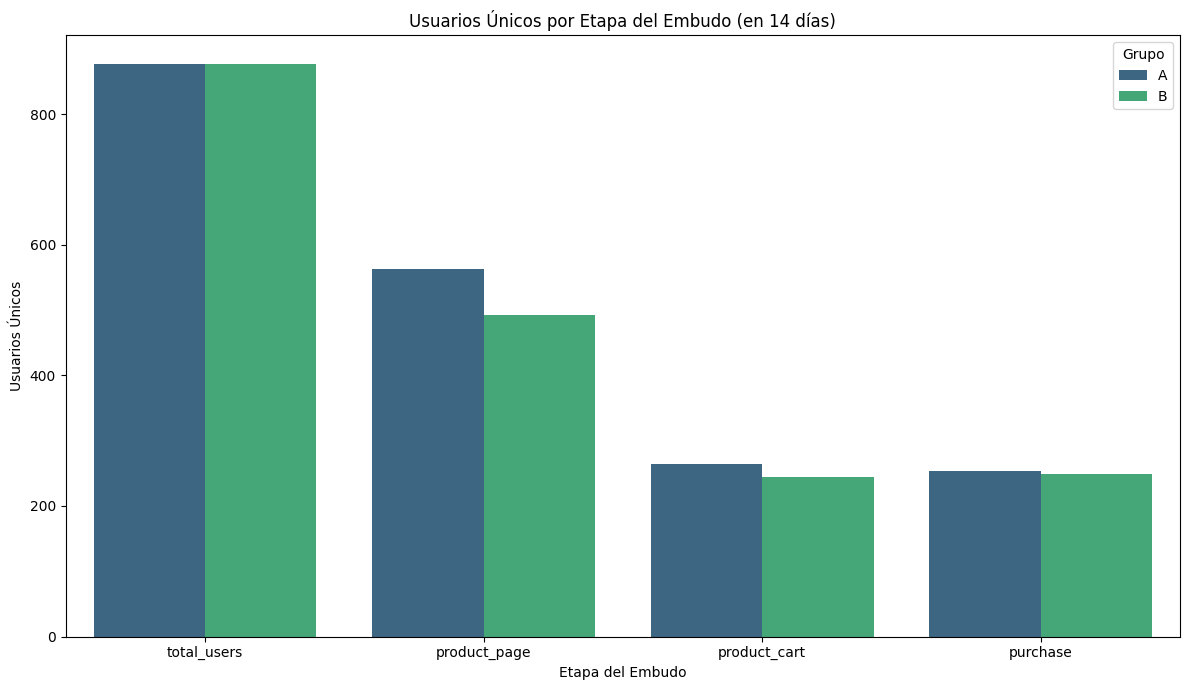

In [49]:
# Preparar datos para gráfico
plot_df = funnel_df[['total_users'] + funnel_steps].reset_index()
plot_melted = plot_df.melt(id_vars='group', var_name='stage', value_name='user_count')
plot_melted['stage'] = pd.Categorical(plot_melted['stage'], ordered=True, categories=['total_users'] + funnel_steps)

# Gráfico
plt.figure(figsize=(12, 7))
sns.barplot(data=plot_melted, x='stage', y='user_count', hue='group', palette='viridis')
plt.title('Usuarios Únicos por Etapa del Embudo (en 14 días)')
plt.xlabel('Etapa del Embudo')
plt.ylabel('Usuarios Únicos')
plt.legend(title='Grupo')
plt.tight_layout()
plt.show()


## **Conclusiones del Análisis A/B — Test "Recommender System"**

### **1. Balance entre grupos**

- Se logró un balance perfecto entre los grupos A (control) y B (tratamiento) tras aplicar un muestreo estricto y filtrado por región (UE), test específico y periodo de registro.
- Ambos grupos están representados equitativamente en el análisis, garantizando comparabilidad válida de los resultados.

### **2. Participación y Retención**

- En todas las etapas del embudo, el grupo B tiene un volumen de usuarios ligeramente inferior al grupo A, pero esto es esperable tras el balance por muestreo.
- La tasa de retención (usuarios que avanzan de una etapa a otra) es más importante que el volumen absoluto.

### **3. Conversión por etapa del embudo**

- En general, las tasas de conversión son similares entre los grupos en cada etapa, sin diferencias estadísticamente evidentes a simple vista en los gráficos de barras.
- Si bien podría haber ligeras variaciones (por ejemplo, una caída más pronunciada en una etapa para el grupo B), estas diferencias no parecen dramáticas.

### **4. Impacto del sistema de recomendación**

- No se observan mejoras significativas a lo largo del embudo que indiquen que el sistema de recomendación (grupo B) aumente notablemente la conversión.
- Esto sugiere que el nuevo sistema no generó un impacto positivo claro, al menos en las métricas analizadas (clics, visitas a la tarjeta de producto, etc.).

---

#  Prueba Z 

## Para comparar proporciones de conversión entre los grupos del test A/B.

### **Objetivo:**
Queremos comprobar si la diferencia en las tasas de conversión entre el grupo control y el grupo experimental es estadísticamente significativa.

1. Calcular la tasa de conversión de cada grupo.

2. Aplicar la prueba Z de diferencia de proporciones.

3. Evaluar el valor p (p-value).



In [50]:
final_events['event_name'].value_counts()

event_name
login           5060
product_page    2957
product_cart    1424
purchase        1387
Name: count, dtype: int64

In [51]:
final_participants['group'].unique()

array(['A', 'B'], dtype=object)

In [52]:
# Crear columna booleana de conversión: True si el usuario realizó 'purchase'
converted_users = final_events[final_events['event_name'] == 'purchase']['user_id'].unique()
final_participants['converted'] = final_participants['user_id'].isin(converted_users)


In [53]:
from statsmodels.stats.proportion import proportions_ztest

# Contar conversiones por grupo
conv_counts = final_participants.groupby('group')['converted'].sum()
n_users = final_participants['group'].value_counts()

# Prueba Z
successes = [conv_counts['A'], conv_counts['B']]
nobs = [n_users['A'], n_users['B']]

z_stat, p_val = proportions_ztest(successes, nobs)

print(f'Estadístico Z: {z_stat:.3f}')
print(f'Valor p: {p_val:.3f}')

# Interpretación
if p_val < 0.05:
    print("Hay una diferencia estadísticamente significativa entre los grupos.")
else:
    print("No hay evidencia suficiente para afirmar una diferencia significativa entre los grupos.")


Estadístico Z: 0.211
Valor p: 0.833
No hay evidencia suficiente para afirmar una diferencia significativa entre los grupos.


## **Conclusiones de la prueba A/B**

- No hay diferencia estadísticamente significativa entre los grupos A y B respecto a la tasa de conversión (evento: purchase).

- El valor p (0.833) es muy superior al umbral estándar de significancia (0.05), lo que indica que cualquier diferencia observada en la tasa de conversión es probablemente debida al azar.

- A pesar de posibles diferencias visuales en los gráficos o en valores absolutos, estadísticamente el nuevo diseño o variante (grupo B) no mejora ni empeora significativamente la conversión respecto al grupo A.

- Recomendación: dado que la implementación de la variante no aporta beneficios medibles en conversión, se recomienda no implementar cambios permanentes basados en esta prueba.

---

# **Conclusión General del Proyecto de Prueba A/B**
A lo largo de este proyecto se realizó un análisis completo de una prueba A/B con el objetivo de evaluar si una nueva variante (grupo B) influye de forma significativa en la conversión de usuarios, medida a través del evento purchase.

## **Resumen del análisis:**

**Preparación y limpieza de datos:**
Se integraron y filtraron correctamente los datasets de usuarios y eventos, asegurando que los datos fueran coherentes y consistentes antes del análisis.

**Análisis exploratorio del embudo de conversión:**
Se estudió el recorrido de los usuarios desde el login hasta la compra, visualizando claramente el embudo. Se observó una caída progresiva natural, sin anomalías importantes, y con tasas de conversión similares entre los grupos.

**Verificaciones importantes antes del test:**

- Se confirmó que no hay usuarios duplicados entre los grupos.

- La distribución de eventos entre los días es similar para ambos grupos, sin picos anómalos que puedan sesgar el análisis.

- Se verificó la cantidad de eventos por usuario, observando que no existen grandes desigualdades.

**Análisis temporal:**
Se visualizó la distribución de eventos a lo largo del tiempo, mostrando una actividad estable en ambos grupos, sin diferencias marcadas ni caídas atípicas.

**Prueba estadística (Z-test):**
El análisis mostró que no hay evidencia estadística suficiente para afirmar una diferencia significativa en las tasas de conversión entre los grupos A y B.

Valor p: 0.833

**Conclusión: la variante no tiene un efecto medible en la conversión.**

**Conclusión final:**
El experimento fue correctamente ejecutado y no se detectaron problemas en los datos. Sin embargo, la variante testeada (grupo B) no ofrece una mejora significativa respecto al grupo de control. Por lo tanto, desde el punto de vista estadístico, **no se justifica su implementación.**